Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from glob import glob

This project entails working with a dataset consisting of around 2,357 images representing different types of skin cancer. The dataset is divided into training and testing sets, each containing nine subdirectories. Each subdirectory is dedicated to a particular type of skin cancer and contains images related to that category. The goal is to develop a model that can correctly classify these images into the appropriate skin cancer type.

In [9]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(r'C:\Users\Sanjay\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train')
data_dir_test = pathlib.Path(r'C:\Users\Sanjay\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test')

In [11]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Create a dataset


In [17]:
batch_size = 32
img_height = 180
img_width = 180

In [19]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [21]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [23]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

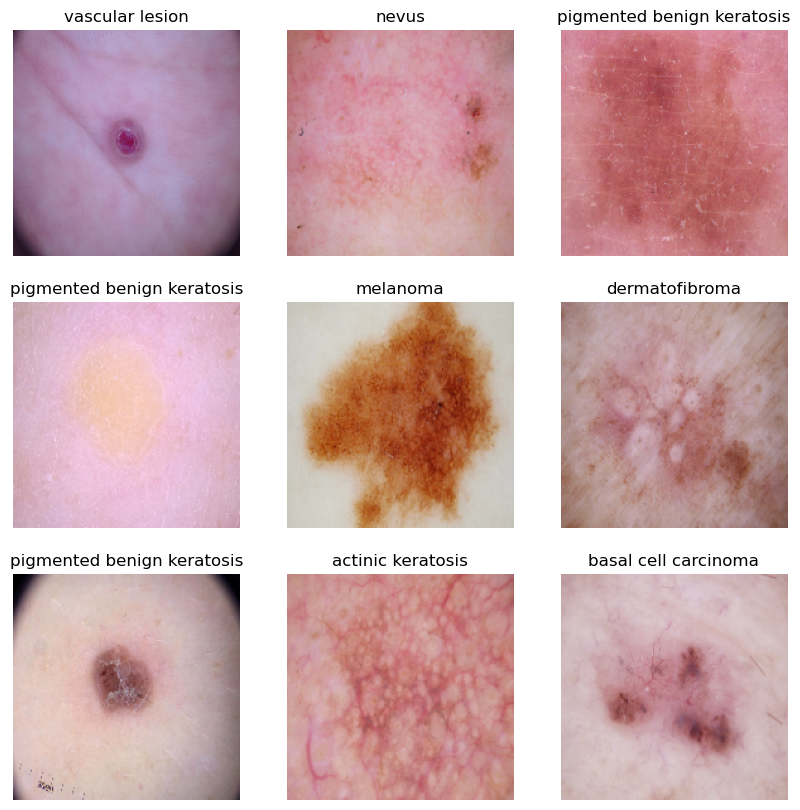

In [28]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [34]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model


In [37]:

target_classes = 9  # Number of target labels for classification

# Build CNN model
def create_model():

    model = Sequential([
        # Rescaling layer to normalize the images
        layers.Rescaling(1./255, input_shape=(180, 180, 3)),

        # First convolutional layer
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Second convolutional layer
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Third convolutional layer
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Dropout layer with 50% fraction
        layers.Dropout(0.5),

        # Flatten layer to convert 3D tensor to 1D tensor
        layers.Flatten(),

        # Fully connected (Dense) layer
        layers.Dense(128, activation='relu'),

        # Dropout layer with 25% fraction
        layers.Dropout(0.25),

        # Output layer with softmax activation for multi-class classification
        layers.Dense(target_classes, activation='softmax')
    ])

    return model

model = create_model()

C:\Users\Sanjay\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.2075 - loss: 2.1587 - val_accuracy: 0.2282 - val_loss: 1.9363
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.3286 - loss: 1.8364 - val_accuracy: 0.4295 - val_loss: 1.6762
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.4124 - loss: 1.6476 - val_accuracy: 0.5235 - val_loss: 1.4818
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.4588 - loss: 1.5029 - val_accuracy: 0.5190 - val_loss: 1.4334
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.4803 - loss: 1.4916 - val_accuracy: 0.5257 - val_loss: 1.4022
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.5343 - loss: 1.4027 - val_accuracy: 0.5190 - val_loss: 1.4123
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.5163 - loss: 1.3421 - val_accuracy: 0.5481 - val_loss: 1.3497
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.5439 - loss: 1.2925 - val_accuracy: 0.5570 - val

### Visualizing training results### Visualizing training results

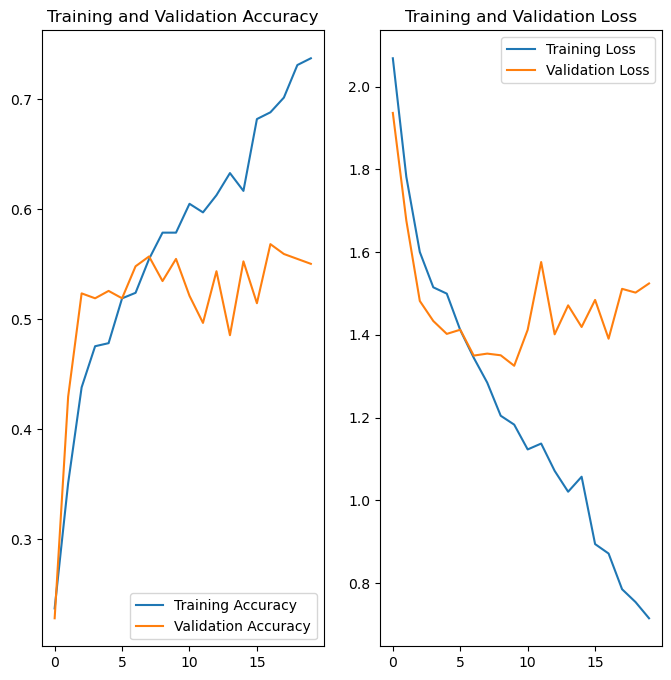

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



# Observations:


Training Accuracy Improvement:
The model shows a steady improvement in training accuracy, reaching approximately 75-80% by the final epochs. This indicates that the CNN is learning patterns from the training data effectively.

Validation Accuracy Fluctuations:
While the validation accuracy improves initially, it stabilizes around 52-55%, with noticeable fluctuations. This suggests that the model is struggling to generalize well to unseen data.

Overfitting Indications:
The widening gap between training and validation accuracy, combined with the increasing validation loss, suggests overfitting. The model has memorized the training data but is not performing well on validation samples.

# model 2

In [67]:
augmentation_data = keras.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])   

C:\Users\Sanjay\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


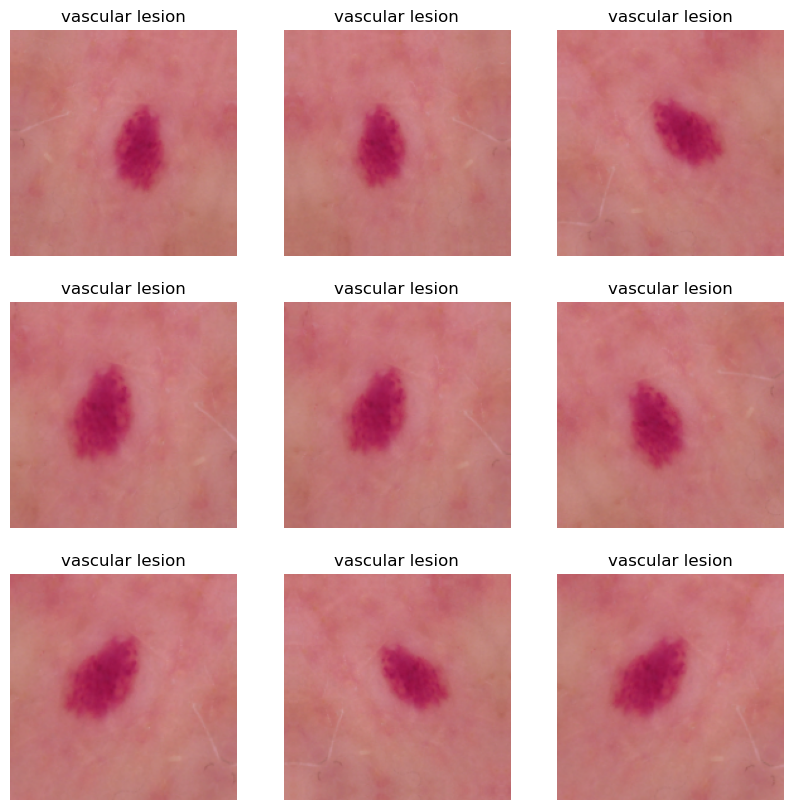

In [69]:
# Visualize augmented images
plt.figure(figsize=(10, 10))

# Take one batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

In [71]:
## we can use Dropout layer if there is an evidence of overfitting in your findings

model = tf.keras.Sequential([
    # Augmentation layer
    augmentation_data,

    # Rescaling layer to normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # First convolutional block
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Second convolutional block
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Third convolutional block
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Dropout layer to prevent overfitting
    layers.Dropout(0.2),

    # Fully connected layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),

    # Output layer with logits for multi-class classification
    layers.Dense(target_classes)
])

C:\Users\Sanjay\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [73]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
#AdamW improves regularization, preventing overfitting

In [75]:

%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 644ms/step - accuracy: 0.1791 - loss: 2.2551 - val_accuracy: 0.3378 - val_loss: 1.9318
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 664ms/step - accuracy: 0.2939 - loss: 1.9115 - val_accuracy: 0.4295 - val_loss: 1.6025
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 635ms/step - accuracy: 0.4420 - loss: 1.6362 - val_accuracy: 0.4944 - val_loss: 1.4525
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 621ms/step - accuracy: 0.4889 - loss: 1.4443 - val_accuracy: 0.5190 - val_loss: 1.5298
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 613ms/step - accuracy: 0.4947 - loss: 1.4182 - val_accuracy: 0.5280 - val_loss: 1.3770
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 562ms/step - accuracy: 0.5220 - loss: 1.3223 - val_accuracy: 0.5570 - val_loss: 1.3395
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 579ms/step - accuracy: 0.5427 - loss: 1.2965 - val_accuracy: 0.4855 - val_loss: 1.4946
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 676ms/step - accuracy: 0.5231 - loss: 1.3390 - val_accu

Visualizing the results


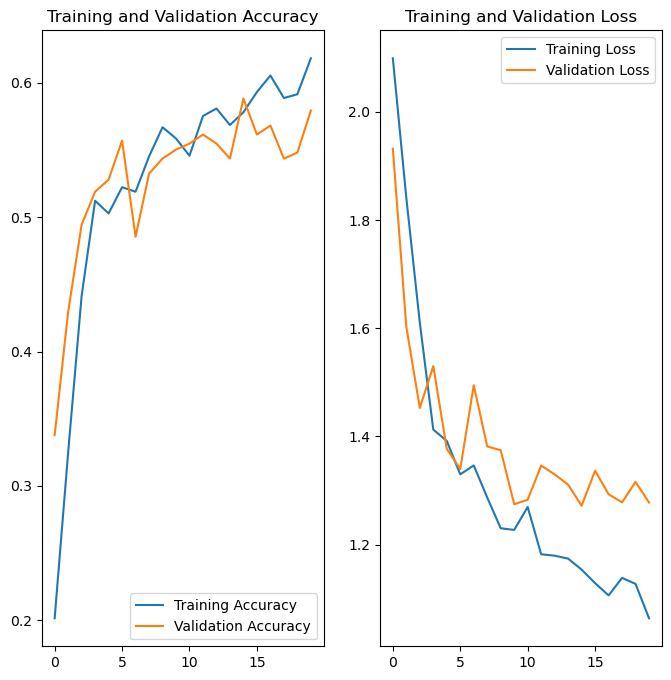

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()  

# Observations:


Training Accuracy Improvement:
The model exhibits a steady improvement in training accuracy, reaching around 65% in the final epochs. This indicates that the CNN is successfully learning from the training data.

Validation Accuracy Trend:
Validation accuracy follows a similar upward trend, peaking at around 58-60%, though it fluctuates slightly. This suggests the model is learning but has some instability in validation performance.

Overfitting Considerations:
Unlike the previous case where overfitting was evident, the training and validation accuracy curves remain relatively close. This suggests that the model is performing better in terms of generalization but might still need slight regularization to stabilize validation accuracy.

# Model 3

In [2]:
import zipfile
import os


zip_file_path = r"C:\Users\Sanjay\Downloads\augmented_dataset"  # Change this to your uploaded ZIP file path
extract_to_path = "/content/drive/MyDrive/CNN"  # Change if you want a different extraction folder

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Files extracted to: {extract_to_path}")

Files extracted to: /content/drive/MyDrive/CNN


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from collections import Counter

# Path to your dataset folder
data_dir = "/content/drive/MyDrive/CNN/augmented_dataset"

# Load images from directory
dataset = image_dataset_from_directory(
    data_dir,
    image_size=(224, 224),  # Resize images (adjust as needed)
    batch_size=32,
    label_mode='int'  # Labels as integers
)

# Get class names (subfolder names)
class_names = dataset.class_names
print("Class Names:", class_names)


Found 4158 files belonging to 9 classes.
Class Names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
import os
import numpy as np
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from collections import Counter

# Define dataset path
DATASET_PATH = r"C:\Users\Sanjay\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
AUGMENTED_PATH = "augmented_dataset"

# Get class distribution
class_counts = {
    'actinic keratosis': 114, 
    'nevus': 357, 
    'pigmented benign keratosis': 462, 
    'melanoma': 438, 
    'basal cell carcinoma': 376, 
    'dermatofibroma': 95, 
    'vascular lesion': 139, 
    'squamous cell carcinoma': 181, 
    'seborrheic keratosis': 77
}

# Determine max count
max_count = max(class_counts.values())  # 462

# Define augmentation settings
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create new dataset directory
os.makedirs(AUGMENTED_PATH, exist_ok=True)

# Balance the dataset
for class_name, count in class_counts.items():
    class_path = os.path.join(DATASET_PATH, class_name)
    save_path = os.path.join(AUGMENTED_PATH, class_name)
    os.makedirs(save_path, exist_ok=True)
    
    # Copy original images
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    for img in image_files:
        shutil.copy(os.path.join(class_path, img), save_path)

    # Augment images if needed
    num_to_generate = max_count - count
    if num_to_generate > 0:
        for i in range(num_to_generate):
            img_file = random.choice(image_files)
            img = load_img(os.path.join(class_path, img_file))  # Load image
            img_array = img_to_array(img)  # Convert to array
            img_array = np.expand_dims(img_array, axis=0)  # Expand dims for augmentation

            aug_iter = datagen.flow(img_array, batch_size=1)
            aug_img = next(aug_iter)[0].astype(np.uint8)

            # Save augmented image
            aug_img_path = os.path.join(save_path, f"aug_{i}_{img_file}")
            shutil.copy(os.path.join(class_path, img_file), aug_img_path)

# Get updated class distribution
new_class_counts = {class_name: max_count for class_name in class_counts}
print("Balanced Class Distribution:", new_class_counts)


In [4]:
# Count number of images per class
class_counts = Counter()

for _, labels in dataset:
    for label in labels.numpy():
        class_counts[label] += 1

# Convert to dictionary with class names
class_counts = {class_names[k]: v for k, v in class_counts.items()}

# Print counts
print("Class Distribution:", class_counts)

Class Distribution: {'actinic keratosis': 462, 'melanoma': 462, 'basal cell carcinoma': 462, 'dermatofibroma': 462, 'pigmented benign keratosis': 462, 'vascular lesion': 462, 'nevus': 462, 'seborrheic keratosis': 462, 'squamous cell carcinoma': 462}


In [15]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [18]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 4158 files belonging to 9 classes.
Using 3327 files for training.


In [19]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 4158 files belonging to 9 classes.
Using 831 files for validation.


In [22]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

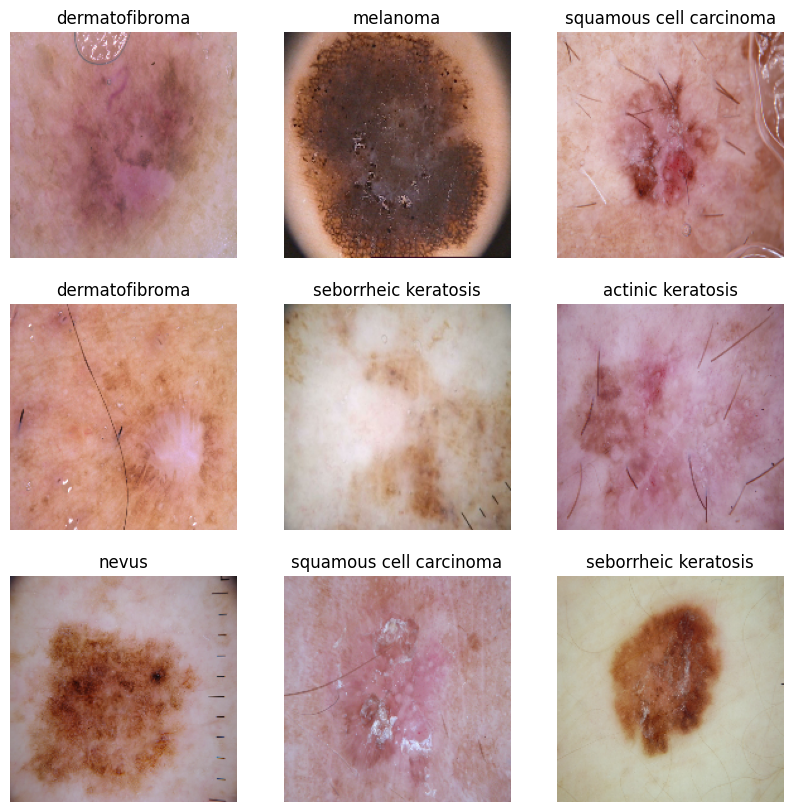

In [23]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
### your code goes here, you can use training or validation data to visualize

In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [28]:
### Your code goes here
import os
import pandas as pd
import pathlib

def class_distribution_count(directory):
    """
    Counts the number of images in each class within a given directory.

    Args:
        directory (str): Path to the directory containing class subdirectories.

    Returns:
        pd.DataFrame: A DataFrame containing class names and their corresponding image counts.
    """
    # Create a dictionary to store class names and their respective counts
    data = {
        "Class": [],
        "No. of Images": []
    }

    # Traverse through subdirectories
    for folder in pathlib.Path(directory).iterdir():
        if folder.is_dir():
            data["Class"].append(folder.name)  # Append class name
            data["No. of Images"].append(sum(1 for _ in folder.glob("*.*")))  # Count image files

    return pd.DataFrame(data)


In [30]:
df = class_distribution_count(data_dir_train)
df.head(10)

,Class,No. of Images
0,actinic keratosis,462
1,basal cell carcinoma,462
2,dermatofibroma,462
3,melanoma,462
4,nevus,462
5,pigmented benign keratosis,462
6,seborrheic keratosis,462
7,squamous cell carcinoma,462
8,vascular lesion,462


### Compile the model
Choose an appropirate optimiser and loss function for model training

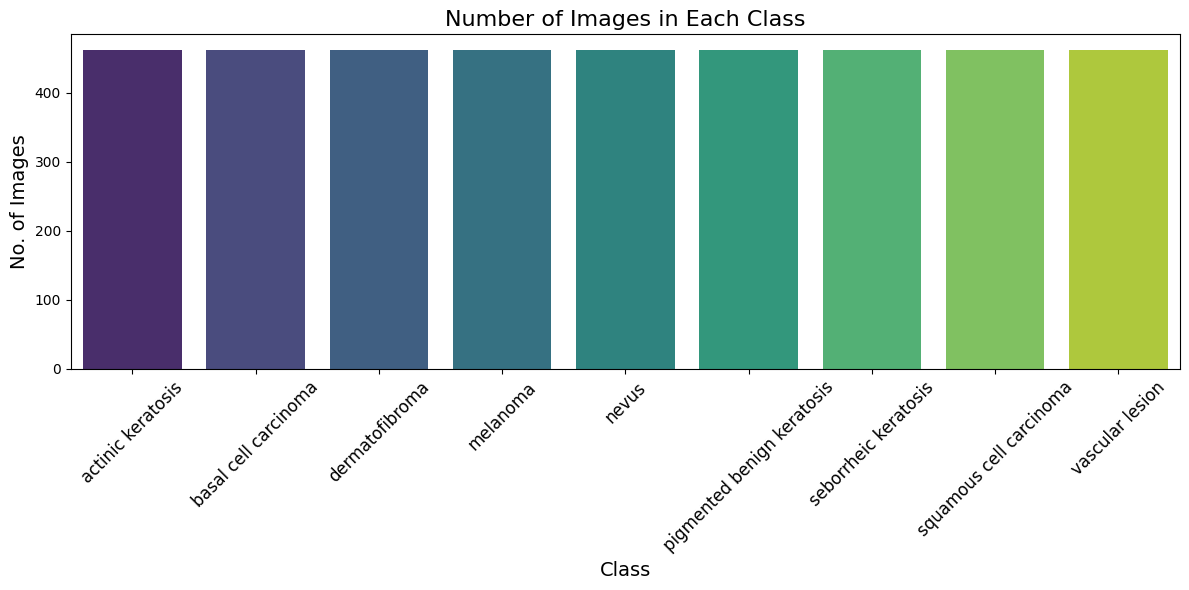

In [27]:

# Visualize the number of images in each class as a vertical bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="No. of Images", hue="Class", data=df, palette="viridis", dodge=False)
plt.title("Number of Images in Each Class", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("No. of Images", fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate class names for better visibility
plt.legend([], [], frameon=False)  # Remove the legend since hue is redundant
plt.tight_layout()
plt.show()

In [33]:
target_classes = 9  # Number of target labels for classification

# Build CNN model
def create_model():

    model = Sequential([
        # Rescaling layer to normalize the images
        layers.Rescaling(1./255, input_shape=(180, 180, 3)),

        # First convolutional layer
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Second convolutional layer
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Third convolutional layer
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Dropout layer with 50% fraction
        layers.Dropout(0.5),

        # Flatten layer to convert 3D tensor to 1D tensor
        layers.Flatten(),

        # Fully connected (Dense) layer
        layers.Dense(128, activation='relu'),

        # Dropout layer with 25% fraction
        layers.Dropout(0.25),

        # Output layer with softmax activation for multi-class classification
        layers.Dense(target_classes, activation='softmax')
    ])

    return model

model = create_model()

C:\Users\Sanjay\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [44]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.1745 - loss: 2.1591 - val_accuracy: 0.3863 - val_loss: 1.6576
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 100s 958ms/step - accuracy: 0.3879 - loss: 1.5939 - val_accuracy: 0.4633 - val_loss: 1.4396
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 142s 956ms/step - accuracy: 0.4614 - loss: 1.4239 - val_accuracy: 0.4681 - val_loss: 1.4811
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 101s 967ms/step - accuracy: 0.5011 - loss: 1.3545 - val_accuracy: 0.5355 - val_loss: 1.3062
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 98s 939ms/step - accuracy: 0.5575 - loss: 1.1823 - val_accuracy: 0.5644 - val_loss: 1.1842
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 97s 933ms/step - accuracy: 0.5773 - loss: 1.1349 - val_accuracy: 0.6113 - val_loss: 1.1662
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.6423 - loss: 0.9941 - val_accuracy: 0.6390 - val_loss: 1.0274
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.6789 - loss: 0.89

### Visualizing training results

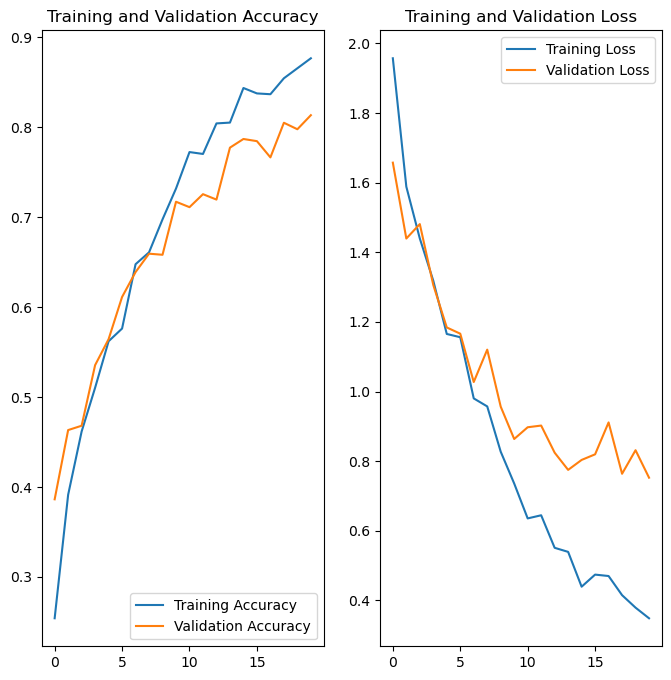

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



# Observations


Training Accuracy Improvement:
The model shows a consistent increase in training accuracy, reaching around 88-90% by the final epochs. This indicates strong learning from the training dataset.

Validation Accuracy Trend:
The validation accuracy also improves steadily, reaching approximately 80-82%, though it exhibits slight fluctuations. The relatively high validation accuracy suggests that the model is generalizing well to unseen data.

Reduced Overfitting:
The gap between training and validation accuracy is present but not excessively large, meaning overfitting is less severe than in previous cases. However, there is still room for improvement to further reduce this gap.

In [48]:
# Get true labels and predictions
y_true = np.concatenate([y for x, y in val_ds], axis=0)  # Extract true labels
y_pred_probs = model.predict(val_ds)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step


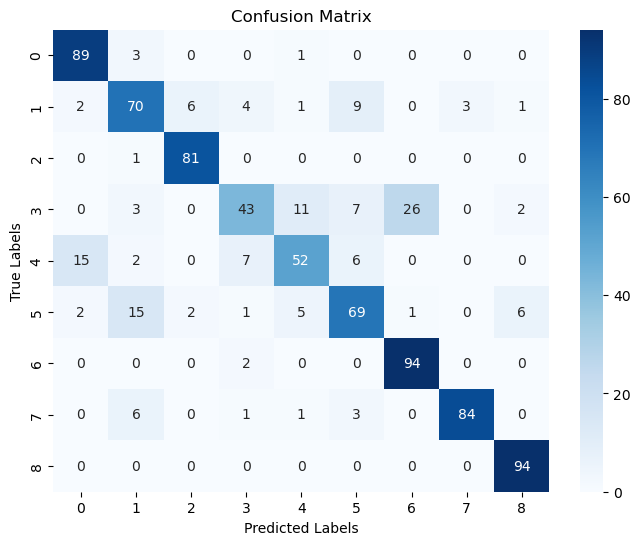

In [50]:
 from sklearn.metrics import confusion_matrix, classification_report
 #Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [52]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89        93
           1       0.70      0.73      0.71        96
           2       0.91      0.99      0.95        82
           3       0.74      0.47      0.57        92
           4       0.73      0.63      0.68        82
           5       0.73      0.68      0.71       101
           6       0.78      0.98      0.87        96
           7       0.97      0.88      0.92        95
           8       0.91      1.00      0.95        94

    accuracy                           0.81       831
   macro avg       0.81      0.81      0.81       831
weighted avg       0.81      0.81      0.81       831



Observations on Classification Report:
Overall Model Performance:

The model has an accuracy of 81%, which is decent for a multi-class classification task.

Both macro and weighted averages of precision, recall, and F1-score are also at 81%, indicating balanced performance across classes.

Class-wise Performance:

Best-performing classes:

Class 8 has perfect recall (1.00) and a high F1-score (0.95), meaning all instances of this class were correctly identified.

Class 7 also has a strong performance with an F1-score of 0.92 and high precision (0.97).

Weaker-performing classes:

Class 3 shows the lowest recall (0.47), indicating that many actual instances of this class were misclassified.

Class 5 and 6 also have lower recall values (0.68), meaning the model struggles to correctly capture all instances of these classes.

Precision vs. Recall Imbalance:

For some classes (e.g., class 3 and 5), recall is significantly lower than precision, indicating that the model is more likely to miss identifying true positive cases for these classes.

A balanced precision-recall distribution is seen for some well-performing classes (e.g., class 8, class 7).

In [74]:
model_1 = tf.keras.models.load_model("my_model_new.h5")

In [90]:
# Save the trained model
model.save("my_model.keras")  # Saves in the recommended Keras format

# Load the model
model = tf.keras.models.load_model("my_model.keras")

C:\Users\Sanjay\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [98]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = r"C:\Users\Sanjay\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\ISIC_0032356.jpg"  # Change this to your image path
img = image.load_img(img_path, target_size=(180, 180))  # Resize to match model input
img_array = image.img_to_array(img)  # Convert to NumPy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize (since model includes Rescaling)

# Make a prediction
prediction = model.predict(img_array)

# Print raw prediction values
print("Raw predictions:", prediction)

# Get the predicted class index
predicted_class = np.argmax(prediction)

print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Raw predictions: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 2.4963673e-31
  2.5957277e-19 1.9380602e-27 0.0000000e+00 0.0000000e+00]]
Predicted class: 3


In [88]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = "ISIC_0031215.jpg"

# Load image and resize to match model input size
img = image.load_img(img_path, target_size=(180, 180))  # Resize to (180,180)
img_array = image.img_to_array(img)  # Convert to NumPy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize pixel values to [0,1]

# Make a prediction
prediction = model_1.predict(img_array)

# If using softmax (multi-class), get class index
predicted_class = np.argmax(prediction)

print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted class: 3
